# SMS Spam Detection using TensorFlow in Python

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
df = pd.read_csv('https://media.geeksforgeeks.org/wp-content/uploads/20240917152755/spam.csv')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


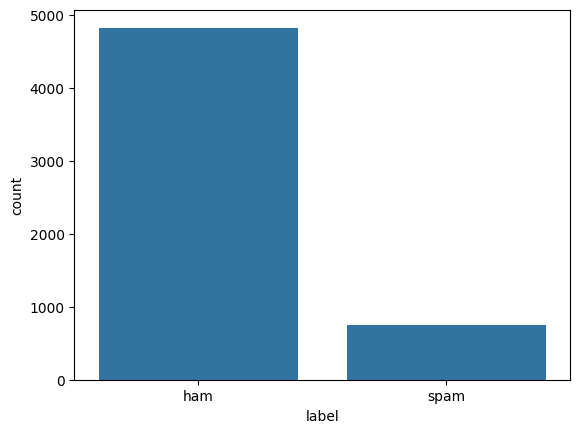

In [6]:
sns.countplot(x=df['label'])
plt.show()

In [7]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

16


In [8]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15686


In [9]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

Model 1: Creating custom Text vectorization and embedding layers:
Text vectorization is the process of converting text into a numerical representation. Example: Bag of words frequency, Binary Term frequency, etc.;

A word embedding is a learned representation of text in which words with related meanings have similar representations. Each word is assigned to a single vector, and the vector values are learned like that of a neural network.

Now, we’ll create a custom text vectorization layer using TensorFlow.

In [11]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [12]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1-score': f1}

    return model_results_dict

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):
  '''
  fit the model with given epochs, train
  and test data
  '''
  # Check if validation data is provided
  if X_test is not None and y_test is not None:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      validation_data=(X_test, y_test)) #Removed validation steps argument
  else:
      # Handle case where validation data is not provided
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs)
  return history

Model -2 Bidirectional LSTM
A bidirectional LSTM (Long short-term memory) is made up of two LSTMs, one accepting input in one direction and the other in the other. BiLSTMs effectively improve the network’s accessible information, boosting the context for the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).

Building and compiling the model-2

In [16]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test) # fit the model


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.9182 - loss: 0.2696 - val_accuracy: 0.9785 - val_loss: 0.0724
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9888 - loss: 0.0402 - val_accuracy: 0.9821 - val_loss: 0.0625
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9952 - loss: 0.0147 - val_accuracy: 0.9839 - val_loss: 0.0668
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 0.9839 - val_loss: 0.0938
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9839 - val_loss: 0.0937


Analyzing our Model Performance

We will use the helper function which we created earlier to evaluate model performance.

In [21]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results}).transpose()

total_results

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.963229,1.000000,0.724832,0.840467
Custom-Vec-Embedding Model,0.330045,0.156322,0.912752,0.266928
Bidirectional-LSTM Model,0.980269,0.950355,0.899329,0.924138
